# Price Predictor Parameter Optimisation

In [1]:
import src.utils.file_management as filemgmt
import src.pipeline.preprocessing as prep
import src.pipeline.predictors as predictors
from src.pipeline.predictors import LSTMPredictor

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Literal, Union

from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

In [4]:
ROOT = Path().resolve().parent

DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_price_downloads"
MINUTELY_PRICES = DATA / "minutely_price_downloads"
#INTERPOLATED_PRICES = DATA / "interpolated_prices"
INTERPOLATED_SMOOTHED_PRICES = DATA / "interpolated_smoothed_prices"

SAVED_MODELS = DATA / "saved_models" / "smoothed_data"

## Parametrisation Short-Term - a2
Predict **4 hours** based on **15-minutely price data** of the **last 8 hours**.

In [16]:
a2_results = predictors.predictor_parametrisation_loop(evaluate_hit_rate=True,
                                                       sort_metric='Val HR',
                                                       n_train_epochs=200,
                                                       early_stopping_patience=20,
                                                       sampling_rate_minutes=15,  # 15 minutes
                                                       price_csv_path=filemgmt.most_recent_file(INTERPOLATED_SMOOTHED_PRICES, '.csv', 'at 15min'),
                                                       daily_prediction_hour=16,
                                                       predict_before_daily_prediction_hour=False,
                                                       rolling_window_size=32,
                                                       forecast_horizon=16,
                                                       batch_size=64,
                                                       validation_split=0.1,
                                                       model_save_directory=SAVED_MODELS / "predictor_a2",
                                                       # parameters to optimise for:
                                                       hidden_lstm_layer_size_set=[128, 256],  # 64 (was mostly worse)
                                                       n_lstm_layers_set=[3, 4],  # 2 (was mostly worse)
                                                       forecast_step_loss_weight_range_set=[(1, .7), (.85, .85),
                                                                                            (.7, 1)],
                                                       use_pre_lstm_fc_layer_set=[False],  # True (maybe simplicity is key?)
                                                       use_final_hidden_state_set=[True],  # False  (settings seems to have negligible impact)
                                                       dropout_set=[.4],  # .3  (.4 seems to generalise better, as expected)
                                                       )
a2_results

Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2769 observations.


Train loss: 0.03634208848234266 | Val Loss: 4.145623028278351  | Patience 19/20 | LRate: 0.000125 | Progress:  14%|█▎        | 27/200 [02:07<13:38,  4.73s/it]


Early stopping triggered at validation loss of 4.186663746833801


100%|██████████| 277/277 [00:02<00:00, 94.52it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2769 observations.


Train loss: 0.03844825329724699 | Val Loss: 3.867366850376129  | Patience 19/20 | LRate: 0.000125 | Progress:  13%|█▎        | 26/200 [02:01<13:32,  4.67s/it]


Early stopping triggered at validation loss of 3.5546432435512543


100%|██████████| 277/277 [00:02<00:00, 99.40it/s] 
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2769 observations.


Train loss: 0.028598237433470786 | Val Loss: 3.057016760110855  | Patience 19/20 | LRate: 9.765625e-07 | Progress:  52%|█████▎    | 105/200 [07:41<06:57,  4.40s/it] 


Early stopping triggered at validation loss of 3.077138364315033


100%|██████████| 277/277 [00:02<00:00, 98.35it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2769 observations.


Train loss: 0.036450627143494785 | Val Loss: 4.307117402553558  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 24/200 [02:35<19:00,  6.48s/it]


Early stopping triggered at validation loss of 3.797271877527237


100%|██████████| 277/277 [00:03<00:00, 78.03it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2769 observations.


Train loss: 0.040200681425631046 | Val Loss: 4.068845629692078  | Patience 19/20 | LRate: 0.000125 | Progress:  10%|█         | 21/200 [02:19<19:44,  6.62s/it]


Early stopping triggered at validation loss of 3.6798634380102158


100%|██████████| 277/277 [00:03<00:00, 78.61it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2769 observations.


Train loss: 0.04195999255171046 | Val Loss: 3.564111292362213  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 24/200 [02:37<19:12,  6.55s/it]


Early stopping triggered at validation loss of 3.6155418157577515


100%|██████████| 277/277 [00:03<00:00, 86.58it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2769 observations.


Train loss: 0.05233658803626895 | Val Loss: 4.020478963851929  | Patience 5/20 | LRate: 0.0005 | Progress:   7%|▋         | 14/200 [02:44<36:25, 11.75s/it] 


KeyboardInterrupt: 

## Parametrisation Mid-Term - b1
Predict **1 day** based on **hourly price data** of the **last week**.

In [15]:
b1_results = predictors.predictor_parametrisation_loop(evaluate_hit_rate=True,
                                                       sort_metric='Val HR',
                                                       n_train_epochs=200,
                                                       early_stopping_patience=20,
                                                       sampling_rate_minutes=60,  # hourly prices
                                                       price_csv_path=filemgmt.most_recent_file(INTERPOLATED_SMOOTHED_PRICES, '.csv', 'at 60min'),
                                                       daily_prediction_hour=16,
                                                       predict_before_daily_prediction_hour=True,
                                                       rolling_window_size=14*4+8,  # 1 week hindsight (4 days a 14 hours and 1 a 8 hours until 16.00)
                                                       forecast_horizon=14,
                                                       batch_size=64,
                                                       validation_split=0.1,
                                                       model_save_directory=SAVED_MODELS / "predictor_b1",
                                                       # parameters to optimise for:
                                                       hidden_lstm_layer_size_set=[128, 256],  # 64 (was mostly worse)
                                                       n_lstm_layers_set=[3, 4],  # 2 (was mostly worse)
                                                       forecast_step_loss_weight_range_set=[(1, .7), (.85, .85),
                                                                                            (.7, 1)],
                                                       use_pre_lstm_fc_layer_set=[False],  # True (maybe simplicity is key?)
                                                       use_final_hidden_state_set=[True],  # False  (settings seems to have negligible impact)
                                                       dropout_set=[.4],  # .3  (.4 seems to generalise better, as expected)
                                                       )
b1_results

Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.09590099670458585 | Val Loss: 5.008342802524567  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 23/200 [02:27<18:52,  6.40s/it]


Early stopping triggered at validation loss of 5.317424714565277


100%|██████████| 277/277 [00:02<00:00, 100.13it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.09433711087331176 | Val Loss: 4.209865510463715  | Patience 19/20 | LRate: 7.8125e-06 | Progress:  27%|██▋       | 54/200 [05:27<14:44,  6.06s/it] 


Early stopping triggered at validation loss of 4.132578730583191


100%|██████████| 277/277 [00:02<00:00, 98.06it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.10400524432770908 | Val Loss: 3.9685437083244324  | Patience 19/20 | LRate: 6.25e-05 | Progress:  16%|█▌        | 31/200 [03:09<17:15,  6.13s/it]


Early stopping triggered at validation loss of 4.297987103462219


100%|██████████| 277/277 [00:02<00:00, 102.76it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.10000602109357715 | Val Loss: 3.954395115375519  | Patience 19/20 | LRate: 0.000125 | Progress:  11%|█         | 22/200 [03:19<26:51,  9.06s/it]


Early stopping triggered at validation loss of 3.58964741230011


100%|██████████| 277/277 [00:03<00:00, 82.80it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.10028901428449899 | Val Loss: 3.8436952233314514  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 23/200 [03:27<26:33,  9.00s/it]


Early stopping triggered at validation loss of 4.200028955936432


100%|██████████| 277/277 [00:03<00:00, 80.18it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.1083264909684658 | Val Loss: 3.794697403907776  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 24/200 [03:34<26:14,  8.95s/it] 


Early stopping triggered at validation loss of 4.141034096479416


100%|██████████| 277/277 [00:03<00:00, 80.18it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.0915774944005534 | Val Loss: 4.653989374637604  | Patience 19/20 | LRate: 0.000125 | Progress:  14%|█▍        | 28/200 [07:44<47:33, 16.59s/it] 


Early stopping triggered at validation loss of 4.741025149822235


100%|██████████| 277/277 [00:03<00:00, 73.81it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.09952897066250443 | Val Loss: 4.5220271944999695  | Patience 19/20 | LRate: 0.000125 | Progress:  11%|█         | 22/200 [06:08<49:41, 16.75s/it]


Early stopping triggered at validation loss of 4.911805212497711


100%|██████████| 277/277 [00:04<00:00, 68.08it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.10189509997144341 | Val Loss: 6.114156484603882  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 23/200 [06:22<49:05, 16.64s/it]


Early stopping triggered at validation loss of 5.612504959106445


100%|██████████| 277/277 [00:03<00:00, 70.66it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.09528303646948189 | Val Loss: 4.039205968379974  | Patience 19/20 | LRate: 0.000125 | Progress:  10%|█         | 21/200 [07:58<1:07:54, 22.77s/it]


Early stopping triggered at validation loss of 3.841885417699814


100%|██████████| 277/277 [00:05<00:00, 54.84it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.0998441691044718 | Val Loss: 4.147518455982208  | Patience 19/20 | LRate: 0.000125 | Progress:  10%|█         | 21/200 [07:54<1:07:20, 22.57s/it]


Early stopping triggered at validation loss of 4.24059134721756


100%|██████████| 277/277 [00:05<00:00, 52.87it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2764 observations.


Train loss: 0.10226625483483076 | Val Loss: 5.693897366523743  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 24/200 [09:05<1:06:41, 22.73s/it]


Early stopping triggered at validation loss of 5.646615624427795


100%|██████████| 277/277 [00:05<00:00, 51.48it/s]


,Hidden Layer Size,N. LSTM Layers,Loss Weight Range,Pre-LSTM FC Layer,Final Hidden State,Dropout,Train Loss,Val Loss,Train HR,Val HR
7,256,3,"(0.85, 0.85)",False,True,0.4,0.09791,4.911805,0.516285,0.509025
1,128,3,"(0.85, 0.85)",False,True,0.4,0.094887,4.132579,0.498191,0.505415
5,128,4,"(0.7, 1)",False,True,0.4,0.108943,4.141034,0.485726,0.505415
6,256,3,"(1, 0.7)",False,True,0.4,0.088177,4.741025,0.49417,0.505415
0,128,3,"(1, 0.7)",False,True,0.4,0.096117,5.317425,0.492963,0.501805
2,128,3,"(0.7, 1)",False,True,0.4,0.105817,4.297987,0.501809,0.501805
4,128,4,"(0.85, 0.85)",False,True,0.4,0.102449,4.200029,0.516285,0.501805
8,256,3,"(0.7, 1)",False,True,0.4,0.103012,5.612505,0.49618,0.498195
9,256,4,"(1, 0.7)",False,True,0.4,0.094466,3.841885,0.491757,0.498195
3,128,4,"(1, 0.7)",False,True,0.4,0.098504,3.589647,0.48452,0.494585


## Parametrisation Mid-Term - b3
Predict **1 week** based on **daily price data** of the **last 2 months**. 

In [14]:
b3_results = predictors.predictor_parametrisation_loop(evaluate_hit_rate=True,
                                                       sort_metric='Val HR',
                                                       n_train_epochs=200,
                                                       early_stopping_patience=20,
                                                       sampling_rate_minutes=60 * 14,  # one day from 8am to 22pm
                                                       price_csv_path=filemgmt.most_recent_file(INTERPOLATED_SMOOTHED_PRICES, '.csv', 'at 1d'),
                                                       daily_prediction_hour=16,
                                                       predict_before_daily_prediction_hour=True,  # irrelevant
                                                       rolling_window_size=2*4*5,  # 2 months a 4 weeks a 5 days hindsight
                                                       forecast_horizon=5,  # i.e. 1 week á 5 days
                                                       batch_size=64,
                                                       validation_split=0.1,
                                                       model_save_directory=SAVED_MODELS / "predictor_b3",
                                                       # parameters to optimise for:
                                                       hidden_lstm_layer_size_set=[128, 256],  # 64 (was mostly worse)
                                                       n_lstm_layers_set=[3, 4],  # 2 (was mostly worse)
                                                       forecast_step_loss_weight_range_set=[(1, .7), (.85, .85),
                                                                                            (.7, 1)],
                                                       use_pre_lstm_fc_layer_set=[False],  # True (maybe simplicity is key?)
                                                       use_final_hidden_state_set=[True],  # False  (settings seems to have negligible impact)
                                                       dropout_set=[.4],  # .3  (.4 seems to generalise better, as expected)
                                                       )
b3_results

Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.23178177000954747 | Val Loss: 1.9845280647277832  | Patience 19/20 | LRate: 6.25e-05 | Progress:  24%|██▍       | 48/200 [02:43<08:38,  3.41s/it]


Early stopping triggered at validation loss of 2.060401111841202


100%|██████████| 273/273 [00:01<00:00, 259.17it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.22919574892148376 | Val Loss: 1.9960997998714447  | Patience 19/20 | LRate: 3.125e-05 | Progress:  30%|███       | 60/200 [03:12<07:28,  3.20s/it]


Early stopping triggered at validation loss of 1.7760909497737885


100%|██████████| 273/273 [00:01<00:00, 250.43it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.24088628962635994 | Val Loss: 2.0077984631061554  | Patience 19/20 | LRate: 6.25e-05 | Progress:  24%|██▎       | 47/200 [02:30<08:09,  3.20s/it]


Early stopping triggered at validation loss of 1.8894870281219482


100%|██████████| 273/273 [00:01<00:00, 253.05it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.21400746214203537 | Val Loss: 1.7603096812963486  | Patience 19/20 | LRate: 0.000125 | Progress:  22%|██▏       | 44/200 [03:26<12:11,  4.69s/it]


Early stopping triggered at validation loss of 1.6546754613518715


100%|██████████| 273/273 [00:01<00:00, 196.11it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.30048364074900746 | Val Loss: 2.5321421921253204  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 23/200 [01:50<14:09,  4.80s/it]


Early stopping triggered at validation loss of 2.3818145394325256


100%|██████████| 273/273 [00:01<00:00, 200.66it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.2210663789883256 | Val Loss: 1.9434847235679626  | Patience 19/20 | LRate: 3.90625e-06 | Progress:  49%|████▉     | 98/200 [07:32<07:51,  4.62s/it]


Early stopping triggered at validation loss of 1.7084141075611115


100%|██████████| 273/273 [00:01<00:00, 196.84it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.1956935143098235 | Val Loss: 1.4230476170778275  | Patience 19/20 | LRate: 1.953125e-06 | Progress:  42%|████▏     | 83/200 [11:38<16:24,  8.42s/it]


Early stopping triggered at validation loss of 1.5878761410713196


100%|██████████| 273/273 [00:01<00:00, 167.84it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.20636718580499291 | Val Loss: 2.4164777994155884  | Patience 19/20 | LRate: 6.25e-05 | Progress:  22%|██▎       | 45/200 [06:21<21:52,  8.47s/it]


Early stopping triggered at validation loss of 2.304358124732971


100%|██████████| 273/273 [00:01<00:00, 169.12it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.18730250257067382 | Val Loss: 2.8936528265476227  | Patience 19/20 | LRate: 3.125e-05 | Progress:  26%|██▋       | 53/200 [07:21<20:23,  8.32s/it]


Early stopping triggered at validation loss of 2.8605516850948334


100%|██████████| 273/273 [00:01<00:00, 172.90it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.1765779152046889 | Val Loss: 2.866682380437851  | Patience 19/20 | LRate: 0.000125 | Progress:  24%|██▍       | 48/200 [09:08<28:55, 11.42s/it] 


Early stopping triggered at validation loss of 3.2405509650707245


100%|██████████| 273/273 [00:02<00:00, 124.98it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.19195822160691023 | Val Loss: 2.6983207762241364  | Patience 19/20 | LRate: 0.000125 | Progress:  22%|██▏       | 43/200 [08:27<30:51, 11.79s/it]


Early stopping triggered at validation loss of 2.3536068499088287


100%|██████████| 273/273 [00:02<00:00, 124.96it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 2726 observations.


Train loss: 0.19833338167518377 | Val Loss: 2.2712833881378174  | Patience 19/20 | LRate: 1.5625e-05 | Progress:  30%|██▉       | 59/200 [11:27<27:24, 11.66s/it]


Early stopping triggered at validation loss of 2.088192492723465


100%|██████████| 273/273 [00:02<00:00, 125.08it/s]


,Hidden Layer Size,N. LSTM Layers,Loss Weight Range,Pre-LSTM FC Layer,Final Hidden State,Dropout,Train Loss,Val Loss,Train HR,Val HR
11,256,4,"(0.7, 1)",False,True,0.4,0.199685,2.088192,0.640033,0.571429
2,128,3,"(0.7, 1)",False,True,0.4,0.241248,1.889487,0.600489,0.567766
3,128,4,"(1, 0.7)",False,True,0.4,0.215941,1.654675,0.601712,0.556777
7,256,3,"(0.85, 0.85)",False,True,0.4,0.206247,2.304358,0.597228,0.553114
8,256,3,"(0.7, 1)",False,True,0.4,0.189464,2.860552,0.656339,0.553114
1,128,3,"(0.85, 0.85)",False,True,0.4,0.226236,1.776091,0.599266,0.545788
9,256,4,"(1, 0.7)",False,True,0.4,0.173241,3.240551,0.625764,0.545788
10,256,4,"(0.85, 0.85)",False,True,0.4,0.185339,2.353607,0.642071,0.52381
0,128,3,"(1, 0.7)",False,True,0.4,0.221777,2.060401,0.572768,0.501832
4,128,4,"(0.85, 0.85)",False,True,0.4,0.291431,2.381815,0.562576,0.498168


## Parametrisation Long-Term - c1
Predict **3 weeks** based on **weekly price data** of the **last 6 months**.

In [13]:
c1_results = predictors.predictor_parametrisation_loop(evaluate_hit_rate=True,
                                                       sort_metric='Val HR',
                                                       n_train_epochs=200,
                                                       early_stopping_patience=20,
                                                       sampling_rate_minutes=7 * 14 * 60,  # 1 week = 7 days each from 8am to 22pm
                                                       price_csv_path=filemgmt.most_recent_file(INTERPOLATED_SMOOTHED_PRICES, '.csv', 'at 7d'),
                                                       daily_prediction_hour=16,
                                                       predict_before_daily_prediction_hour=True,  # irrelevant
                                                       rolling_window_size=6*4,  # i.e. 6 months á 4 weeks
                                                       forecast_horizon=3,  # i.e. 3 weeks
                                                       batch_size=64,
                                                       validation_split=0.1,
                                                       model_save_directory=SAVED_MODELS / "predictor_c1",
                                                       # parameters to optimise for:
                                                       hidden_lstm_layer_size_set=[128, 256],  # 64 (was mostly worse)
                                                       n_lstm_layers_set=[3, 4],  # 2 (was mostly worse)
                                                       forecast_step_loss_weight_range_set=[(1, .7), (.85, .85),
                                                                                            (.7, 1)],
                                                       use_pre_lstm_fc_layer_set=[False],  # True (maybe simplicity is key?)
                                                       use_final_hidden_state_set=[True],  # False  (settings seems to have negligible impact)
                                                       dropout_set=[.4],  # .3  (.4 seems to generalise better, as expected)
                                                       )
c1_results

Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.13288892526179552 | Val Loss: 0.4664342999458313  | Patience 19/20 | LRate: 6.25e-05 | Progress:  20%|██        | 41/200 [00:16<01:05,  2.44it/s] 


Early stopping triggered at validation loss of 0.4645077586174011


100%|██████████| 53/53 [00:00<00:00, 358.26it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.13020093087106943 | Val Loss: 0.4953591227531433  | Patience 19/20 | LRate: 0.000125 | Progress:  20%|█▉        | 39/200 [00:18<01:15,  2.15it/s]


Early stopping triggered at validation loss of 0.5066105127334595


100%|██████████| 53/53 [00:00<00:00, 416.37it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.15013970341533422 | Val Loss: 0.4530850648880005  | Patience 19/20 | LRate: 3.125e-05 | Progress:  25%|██▌       | 50/200 [00:21<01:05,  2.30it/s]


Early stopping triggered at validation loss of 0.4428817927837372


100%|██████████| 53/53 [00:00<00:00, 396.91it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.14519664365798235 | Val Loss: 0.38651105761528015  | Patience 19/20 | LRate: 0.000125 | Progress:  14%|█▎        | 27/200 [00:16<01:48,  1.60it/s]


Early stopping triggered at validation loss of 0.37886202335357666


100%|██████████| 53/53 [00:00<00:00, 279.50it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.16742044314742088 | Val Loss: 0.4474411606788635  | Patience 19/20 | LRate: 0.000125 | Progress:  15%|█▌        | 30/200 [00:17<01:37,  1.74it/s]


Early stopping triggered at validation loss of 0.47264641523361206


100%|██████████| 53/53 [00:00<00:00, 327.40it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.17453315015882254 | Val Loss: 0.454120934009552  | Patience 19/20 | LRate: 0.000125 | Progress:  13%|█▎        | 26/200 [00:15<01:42,  1.69it/s] 


Early stopping triggered at validation loss of 0.44557985663414


100%|██████████| 53/53 [00:00<00:00, 304.65it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.1137954369187355 | Val Loss: 0.4238089323043823  | Patience 19/20 | LRate: 0.000125 | Progress:  16%|█▌        | 31/200 [00:34<03:06,  1.10s/it] 


Early stopping triggered at validation loss of 0.4264664053916931


100%|██████████| 53/53 [00:00<00:00, 277.99it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.12554242368787527 | Val Loss: 0.4329126179218292  | Patience 19/20 | LRate: 3.125e-05 | Progress:  24%|██▎       | 47/200 [00:49<02:40,  1.05s/it]


Early stopping triggered at validation loss of 0.44285380840301514


100%|██████████| 53/53 [00:00<00:00, 262.40it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.10973221994936466 | Val Loss: 0.4815044403076172  | Patience 19/20 | LRate: 0.000125 | Progress:  20%|██        | 41/200 [00:41<02:40,  1.01s/it]


Early stopping triggered at validation loss of 0.5012462735176086


100%|██████████| 53/53 [00:00<00:00, 277.21it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.13129291031509638 | Val Loss: 0.4490640461444855  | Patience 19/20 | LRate: 0.000125 | Progress:  12%|█▏        | 24/200 [00:33<04:07,  1.41s/it]


Early stopping triggered at validation loss of 0.45000597834587097


100%|██████████| 53/53 [00:00<00:00, 193.63it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.11730059143155813 | Val Loss: 0.4602213501930237  | Patience 19/20 | LRate: 6.25e-05 | Progress:  20%|██        | 40/200 [00:55<03:42,  1.39s/it] 


Early stopping triggered at validation loss of 0.4364528954029083


100%|██████████| 53/53 [00:00<00:00, 210.89it/s]
Train loss: - | Val Loss: - | Patience 0/20 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Resulting dataset consists of 528 observations.


Train loss: 0.12806143891066313 | Val Loss: 0.4461742043495178  | Patience 19/20 | LRate: 0.000125 | Progress:  16%|█▌        | 31/200 [00:44<04:01,  1.43s/it]


Early stopping triggered at validation loss of 0.44590380787849426


100%|██████████| 53/53 [00:00<00:00, 185.09it/s]


,Hidden Layer Size,N. LSTM Layers,Loss Weight Range,Pre-LSTM FC Layer,Final Hidden State,Dropout,Train Loss,Val Loss,Train HR,Val HR
3,128,4,"(1, 0.7)",False,True,0.4,0.152011,0.378862,0.618947,0.490566
5,128,4,"(0.7, 1)",False,True,0.4,0.179686,0.44558,0.576842,0.45283
0,128,3,"(1, 0.7)",False,True,0.4,0.13289,0.464508,0.633684,0.433962
2,128,3,"(0.7, 1)",False,True,0.4,0.149035,0.442882,0.623158,0.433962
10,256,4,"(0.85, 0.85)",False,True,0.4,0.112575,0.436453,0.671579,0.433962
11,256,4,"(0.7, 1)",False,True,0.4,0.126958,0.445904,0.696842,0.433962
1,128,3,"(0.85, 0.85)",False,True,0.4,0.124954,0.506611,0.650526,0.415094
6,256,3,"(1, 0.7)",False,True,0.4,0.113058,0.426466,0.642105,0.415094
9,256,4,"(1, 0.7)",False,True,0.4,0.134458,0.450006,0.612632,0.415094
7,256,3,"(0.85, 0.85)",False,True,0.4,0.120047,0.442854,0.677895,0.377358


## Test

In [3]:
# renew with smoothed_data:
SAVED_B1_PREDICTOR = SAVED_MODELS / "predictor_b1" / "2025-05-22 10_03_41 LSTM Model RW68 FH14 Layers3 Size256 TrainL0.10641186928842217 ValL1.9110333621501923 TrainHR0.4860040545463562 ValHR0.5328466892242432.pt"
SAVED_B3_PREDICTOR = SAVED_MODELS / "predictor_b3" / "2025-05-22 11_47_10 LSTM Model RW40 FH5 Layers3 Size128 TrainL0.36055382899940014 ValL1.9578219056129456 TrainHR0.547325074672699 ValHR0.529629647731781.pt"
SAVED_C1_PREDICTOR = SAVED_MODELS / "predictor_c1" / "2025-05-22 11_27_18 LSTM Model RW24 FH3 Layers4 Size128 TrainL0.29682125337421894 ValL0.4320639967918396 TrainHR0.5574468374252319 ValHR0.5660377144813538.pt"
ENV_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '15min')
B1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '60min')
B3_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '1d')
C1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '7d')

In [4]:
c1_predictor = LSTMPredictor(model_load_file_path=SAVED_C1_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=C1_PRICE_FILE,
                             daily_prediction_hour=20,  # these are necessary data properties which still need to be set
                             rolling_window_size=6*4,  # 6 months a 4 weeks hindsight
                             forecast_horizon=3,  # 3 weeks ahead
                             sampling_rate_minutes=5*14*60,  # 1 week a 5 days from 8 to 22
                             )
#c1_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.


In [8]:
c1_predictor.price_series

date
2014-10-23 16:00:00    19.859246
2014-10-30 16:00:00    20.091760
2014-11-06 16:00:00    20.223222
2014-11-13 16:00:00    20.124641
2014-11-20 16:00:00    20.842549
                         ...    
2025-05-01 16:00:00    41.740000
2025-05-08 16:00:00    42.600000
2025-05-15 16:00:00    42.673310
2025-05-22 16:00:00    43.665000
2025-05-29 16:00:00    44.030000
Name: close, Length: 554, dtype: float64

In [5]:
c1_predictor.plot_prediction_overview()

Created rolling window view based on rolling_window_size of 24 and forecast_horizon of 3 with a time unit of 4200 minutes.
Target values start at only observation between 20:00 and 21:00 daily.


ValueError: No observations remain after choosing observations according to prediction hour of 20.
This can be due to wrong specification of the sampling rate (currently 4200 min)!

## Run

In [77]:
AV_API_KEY_FILE = ROOT / "private" / "Alpha Vantage API Key.txt"
with open(AV_API_KEY_FILE) as file: AV_API_KEY = file.read()

sampling_rate_minutes = 15
ticker = 'Dax'

In [78]:
ts = TimeSeries(key=AV_API_KEY, output_format='pandas')
recent_dax = ts.get_intraday(ticker, interval=f'{sampling_rate_minutes}min',
                             outputsize="compact" if 14 * 60 / sampling_rate_minutes < 100 else "full")
daily_dax = recent_dax[0][recent_dax[0].index.day_of_year == recent_dax[0].index.day_of_year.max()][
    '4. close']  # last day
recent_price_data = prep.time_interpolation_new_sampling_rate(daily_dax, '4. close', 'date',
                                                              f'{sampling_rate_minutes}min',
                                                              manual_operating_hours=(8, 22))
recent_price_data

,close
date,
2025-05-16 08:00:00,43.48750
2025-05-16 08:15:00,43.24000
2025-05-16 08:30:00,42.92000
2025-05-16 08:45:00,42.84000
2025-05-16 09:00:00,42.76000
2025-05-16 09:15:00,42.78000
2025-05-16 09:30:00,42.80000
2025-05-16 09:45:00,42.87500
2025-05-16 10:00:00,42.89790


Prices are expected to go DOWN!


(array([31.8091462 , 31.8301834 , 31.85673586, 31.88494352, 31.91238934,
        31.93949301, 31.96582016, 31.99007451, 32.01100482, 32.02798444,
        32.04102383, 32.05052384, 32.05705088, 32.06117972, 32.06342963,
        32.06423025]),
 DatetimeIndex(['2025-05-16 16:00:00', '2025-05-16 16:15:00',
                '2025-05-16 16:30:00', '2025-05-16 16:45:00',
                '2025-05-16 17:00:00', '2025-05-16 17:15:00',
                '2025-05-16 17:30:00', '2025-05-16 17:45:00',
                '2025-05-16 18:00:00', '2025-05-16 18:15:00',
                '2025-05-16 18:30:00', '2025-05-16 18:45:00',
                '2025-05-16 19:00:00', '2025-05-16 19:15:00',
                '2025-05-16 19:30:00', '2025-05-16 19:45:00'],
               dtype='datetime64[ns]', freq='15min'))

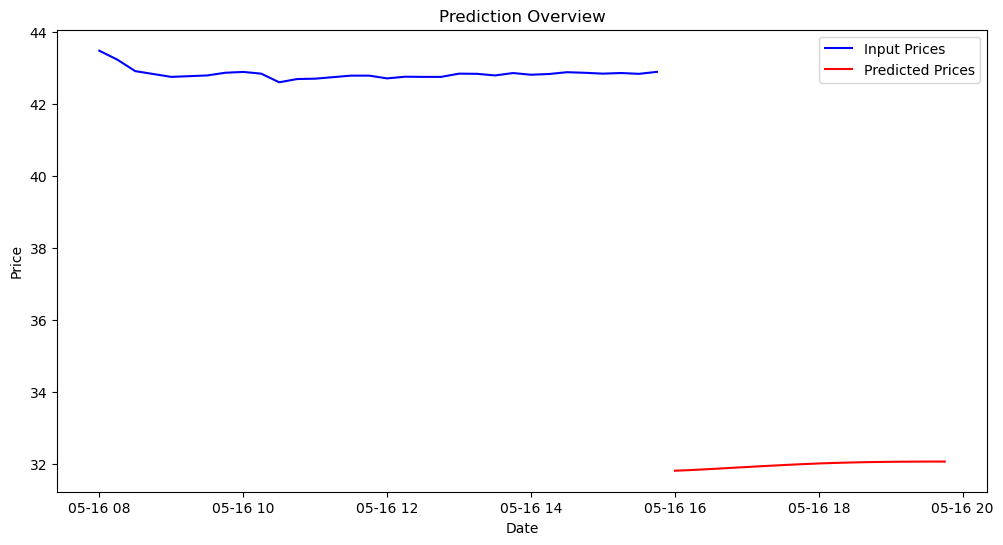

In [79]:
predictor_a2_1.predict(recent_price_data.iloc[:32])